<a href="https://colab.research.google.com/github/aireslucas/MachineLearning/blob/main/Atividade01_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

from sklearn.metrics import mutual_info_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from collections import Counter
from IPython.display import display
import xgboost as xgb

%matplotlib inline
plt.style.use('fivethirtyeight')


#Import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset definition & Head visualization

In [3]:
data = pd.read_csv("/content/drive/MyDrive/ML/MBA.csv")

In [4]:
data.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


#EDA
_____


1. Reading dataset length

In [5]:
len(data)

6194

In [6]:
data.isnull().sum()

,0
application_id,0
gender,0
international,0
gpa,0
major,0
race,1842
gmat,0
work_exp,0
work_industry,0
admission,5194


2. Setting numerical and categorical classes

In [7]:
numerical = ["gpa", "gmat", "work_exp"]
categorical = ["gender", "international", "major", "race", "work_industry", "admission"]

#Exploring numerical values

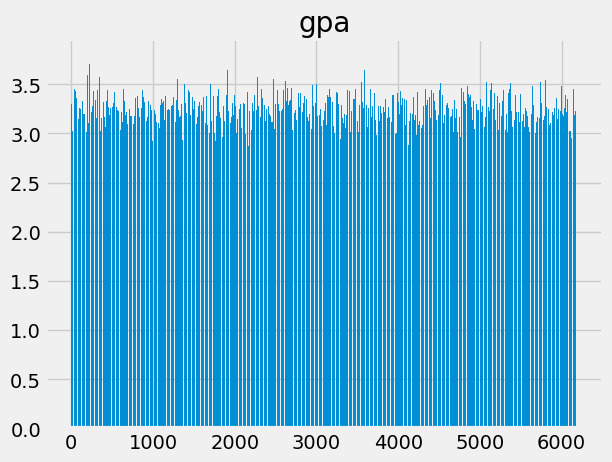

max value: 3.77
min value: 2.65
mean: 3.2507135938004517
median: 3.25


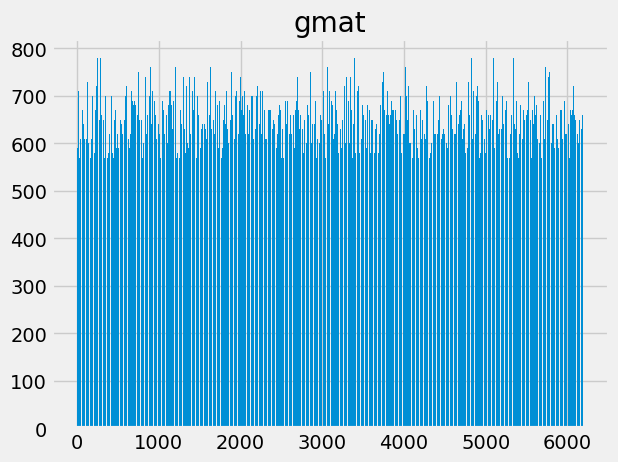

max value: 780.0
min value: 570.0
mean: 651.0929932192445
median: 650.0


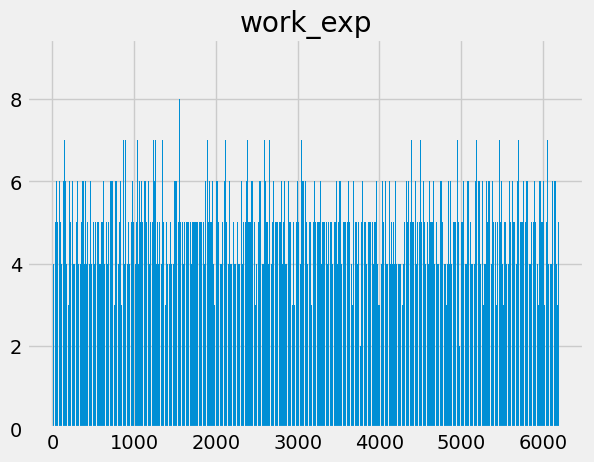

max value: 9.0
min value: 1.0
mean: 5.0169518889247655
median: 5.0


In [8]:
for category in numerical:
    plt.bar(data.application_id, data[category])
    plt.title(category)
    plt.show()
    print(f"max value: {np.max(data[category])}")
    print(f"min value: {np.min(data[category])}")
    print(f"mean: {data[category].mean()}")
    print(f"median: {data[category].median()}")

Text(0.5, 1.0, 'GPA distribution')

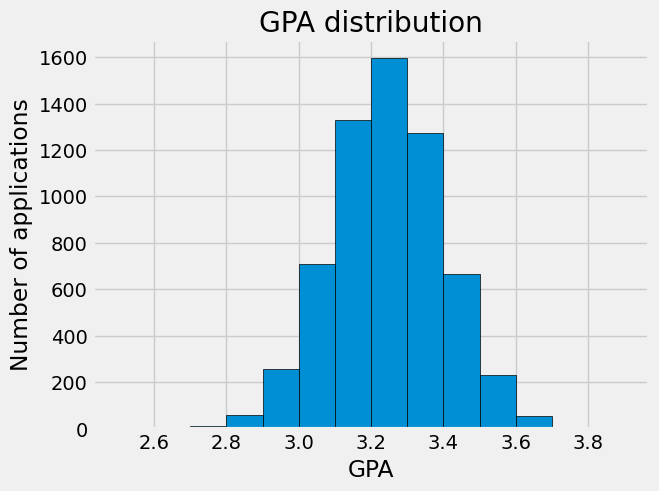

In [9]:
bins = np.arange(2.5, 4, 0.10)
plt.hist(data.gpa, bins=bins, edgecolor='black')
plt.xlabel('GPA')
plt.ylabel('Number of applications')
plt.title("GPA distribution")

Text(0.5, 1.0, 'GMAT')

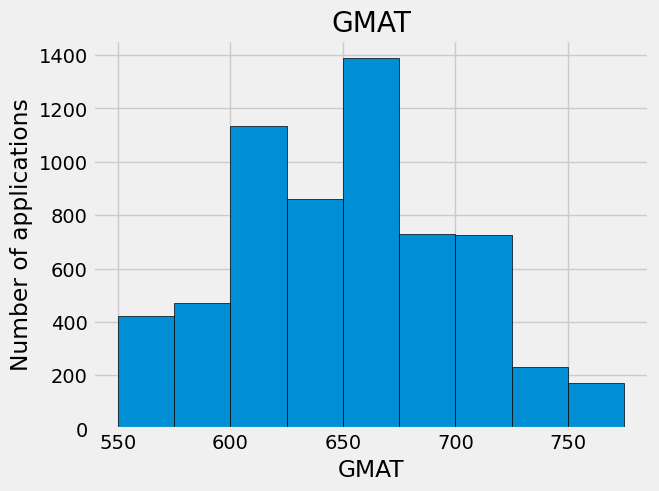

In [10]:
bins = np.arange(550, 800, 25)
plt.hist(data.gmat, bins=bins, edgecolor='black')
plt.xlabel('GMAT')
plt.ylabel('Number of applications')
plt.title("GMAT")

Text(0.5, 1.0, 'Work experience distribution')

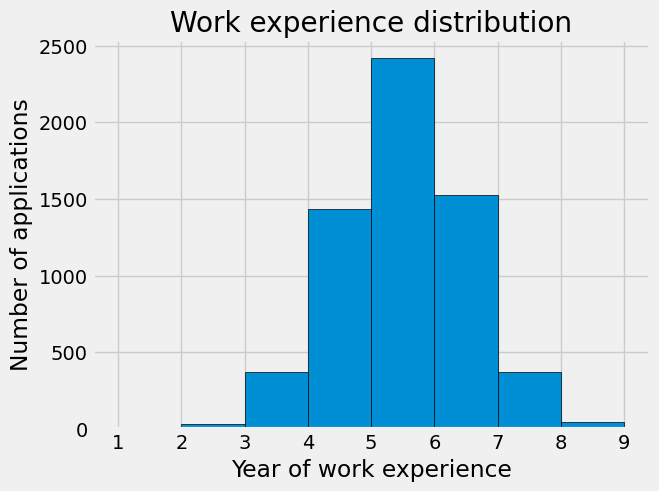

In [11]:
bins = np.arange(1, 10, 1)
plt.hist(data.work_exp, bins=bins, edgecolor='black')
plt.xlabel('Year of work experience')
plt.ylabel('Number of applications')
plt.title("Work experience distribution")


#Exploring categorical values

In [12]:
data[categorical].nunique()

,0
gender,2
international,2
major,3
race,5
work_industry,14
admission,2


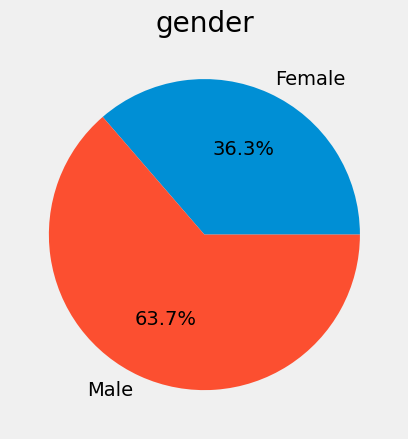

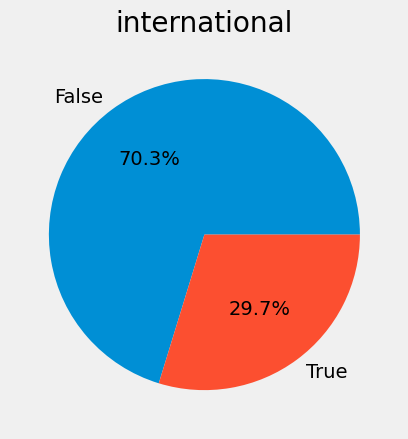

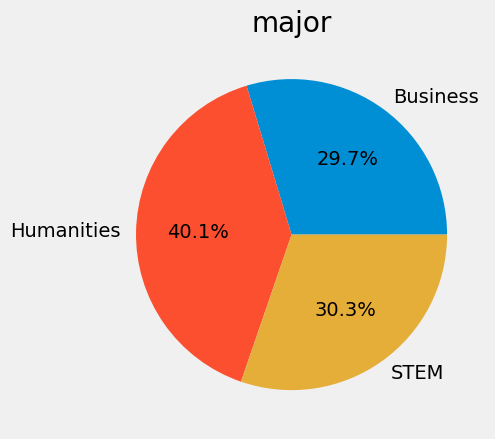

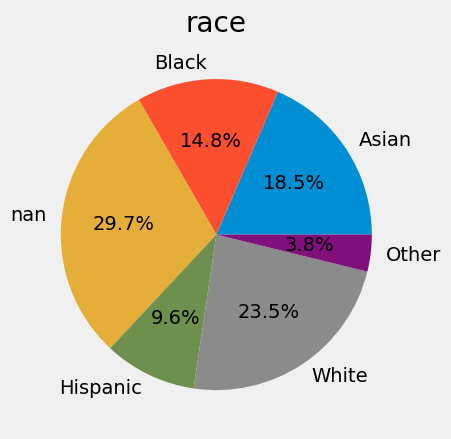

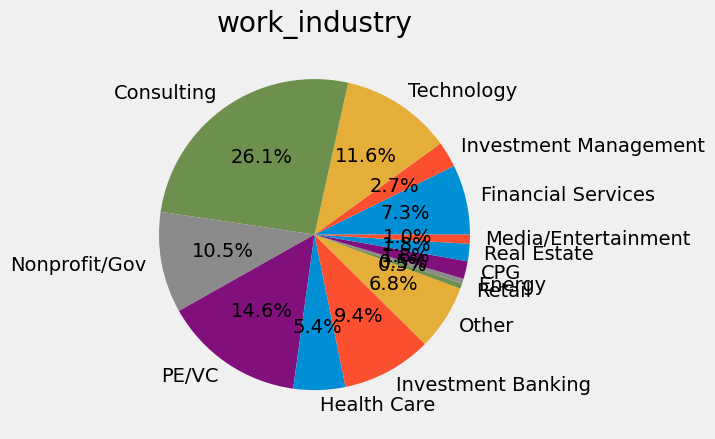

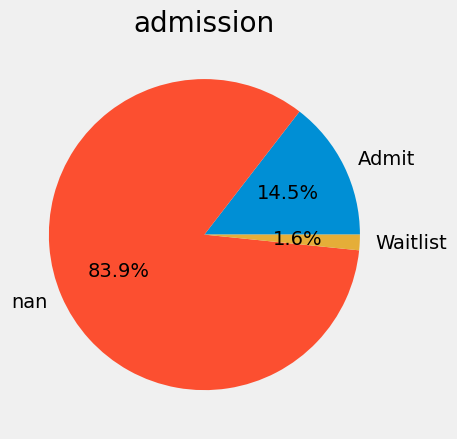

In [13]:
for category in categorical:
    counts_column = Counter(data[category])
    labels = list(counts_column.keys())
    values = list(counts_column.values())
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(category)
    plt.show()

#Preparing admission column
_______
For training and evaluational propourses "Waitlist" in the admission column will be replaced by "Admit".

In [14]:
data.loc[data["admission"] == "Waitlist", "admission"] = "Admit"

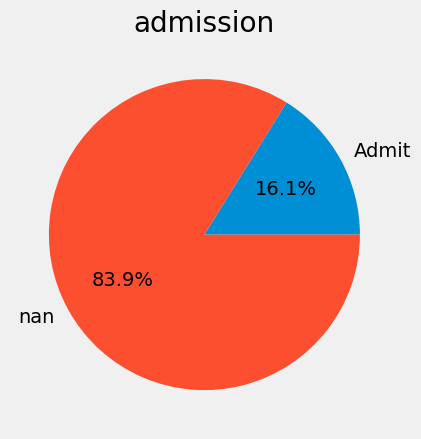

In [15]:
counts_column = Counter(data["admission"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("admission")
plt.show()

In [16]:
data["admission"] = (data["admission"] == "Admit").astype(int)

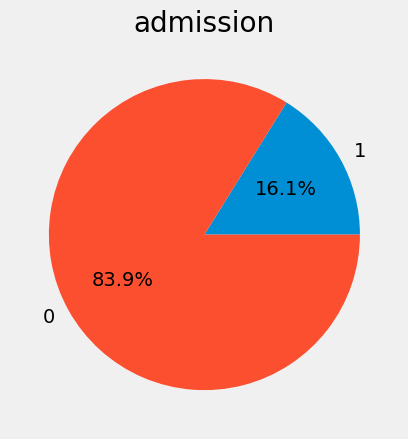

In [17]:
counts_column = Counter(data["admission"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("admission")
plt.show()

#Preparing others columns

In [18]:
data.fillna(value={'race':  "Unknown"}, inplace=True)

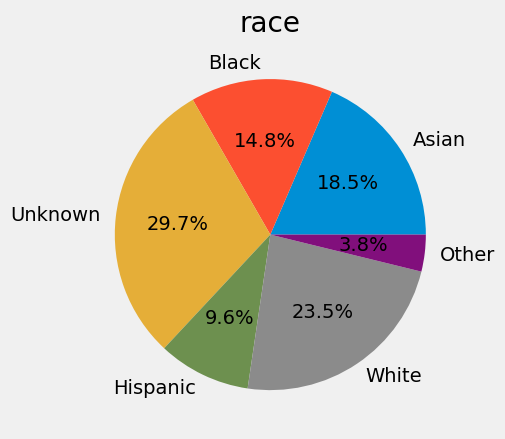

In [19]:
counts_column = Counter(data["race"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("race")
plt.show()

In [20]:
data["gender"] = (data["gender"] == "Male").astype(int)

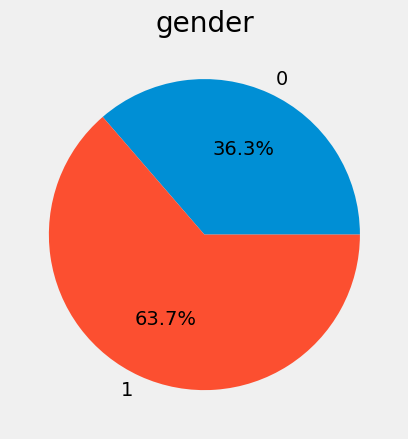

In [21]:
counts_column = Counter(data["gender"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("gender")
plt.show()

In [22]:
data_final = data.copy()

# Lista de colunas categóricas para aplicar o OneHotEncoder
colunas_categoricas = ["major", "work_industry", "race"]

for coluna in colunas_categoricas:
    encoder = OneHotEncoder(sparse_output=False)
    one_hot = encoder.fit_transform(data[[coluna]])
    colunas_onehot = encoder.get_feature_names_out([coluna])
    df_onehot = pd.DataFrame(one_hot, columns=colunas_onehot, index=data.index)

    # Adiciona as colunas codificadas
    data_final = pd.concat([data_final, df_onehot], axis=1)

# Remove as colunas originais
data_final = data_final.drop(columns=colunas_categoricas)

In [23]:
data_final

,application_id,gender,international,gpa,gmat,work_exp,admission,major_Business,major_Humanities,major_STEM,...,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology,race_Asian,race_Black,race_Hispanic,race_Other,race_Unknown,race_White
0,1,0,False,3.30,620.0,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1,False,3.28,680.0,5.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,0,True,3.30,710.0,5.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,1,False,3.47,690.0,6.0,0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,1,False,3.35,590.0,5.0,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6189,6190,1,False,3.49,640.0,5.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6190,6191,1,False,3.18,670.0,4.0,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6191,6192,0,True,3.22,680.0,5.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6192,6193,1,True,3.36,590.0,5.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
data_final.columns

Index(['application_id', 'gender', 'international', 'gpa', 'gmat', 'work_exp',
       'admission', 'major_Business', 'major_Humanities', 'major_STEM',
       'work_industry_CPG', 'work_industry_Consulting', 'work_industry_Energy',
       'work_industry_Financial Services', 'work_industry_Health Care',
       'work_industry_Investment Banking',
       'work_industry_Investment Management',
       'work_industry_Media/Entertainment', 'work_industry_Nonprofit/Gov',
       'work_industry_Other', 'work_industry_PE/VC',
       'work_industry_Real Estate', 'work_industry_Retail',
       'work_industry_Technology', 'race_Asian', 'race_Black', 'race_Hispanic',
       'race_Other', 'race_Unknown', 'race_White'],
      dtype='object')

#Feature importance

In [25]:
categorical = data_final.columns

In [26]:
overall_admision = data_final.admission.mean()
overall_admision

np.float64(0.16144656118824668)

In [27]:
for category in categorical:
    print(category)
    data_category = data_final.groupby(category).admission.agg(mean='mean', count='count')
    data_category['difference'] = data_category['mean'] - overall_admision
    data_category['risk_ratio'] = data_category['mean'] / overall_admision
    display(data_category)
    print()

application_id


,mean,count,difference,risk_ratio
application_id,,,,
1,1.0,1,0.838553,6.194
2,0.0,1,-0.161447,0.000
3,1.0,1,0.838553,6.194
4,0.0,1,-0.161447,0.000
5,0.0,1,-0.161447,0.000
...,...,...,...,...
6190,0.0,1,-0.161447,0.000
6191,0.0,1,-0.161447,0.000
6192,1.0,1,0.838553,6.194



gender


,mean,count,difference,risk_ratio
gender,,,,
0,0.222124,2251,0.060677,1.375833
1,0.126807,3943,-0.034640,0.785443



international


,mean,count,difference,risk_ratio
international,,,,
False,0.159007,4352,-0.002439,0.984892
True,0.167210,1842,0.005763,1.035696



gpa


,mean,count,difference,risk_ratio
gpa,,,,
2.65,0.0,1,-0.161447,0.000
2.72,0.0,1,-0.161447,0.000
2.73,0.0,1,-0.161447,0.000
2.78,0.0,5,-0.161447,0.000
2.79,0.0,1,-0.161447,0.000
...,...,...,...,...
3.71,0.0,2,-0.161447,0.000
3.73,1.0,1,0.838553,6.194
3.74,0.5,2,0.338553,3.097



gmat


,mean,count,difference,risk_ratio
gmat,,,,
570.0,0.014218,422,-0.147229,0.088066
580.0,0.033019,212,-0.128428,0.204519
590.0,0.038462,260,-0.122985,0.238231
600.0,0.038339,313,-0.123108,0.237470
610.0,0.026247,381,-0.135200,0.162572
620.0,0.036446,439,-0.125000,0.225749
630.0,0.045564,417,-0.115883,0.282221
640.0,0.042793,444,-0.118654,0.265059
650.0,0.033259,451,-0.128187,0.206009



work_exp


,mean,count,difference,risk_ratio
work_exp,,,,
1.0,0.500000,2,0.338553,3.097000
2.0,0.093750,32,-0.067697,0.580688
3.0,0.170732,369,0.009285,1.057512
4.0,0.144050,1437,-0.017396,0.892246
5.0,0.169078,2419,0.007632,1.047270
6.0,0.168848,1528,0.007402,1.045846
7.0,0.152589,367,-0.008858,0.945134
8.0,0.078947,38,-0.082499,0.489000
9.0,0.000000,2,-0.161447,0.000000



admission


,mean,count,difference,risk_ratio
admission,,,,
0,0.0,5194,-0.161447,0.000
1,1.0,1000,0.838553,6.194



major_Business


,mean,count,difference,risk_ratio
major_Business,,,,
0.0,0.162534,4356,0.001088,1.006738
1.0,0.158868,1838,-0.002578,0.984030



major_Humanities


,mean,count,difference,risk_ratio
major_Humanities,,,,
0.0,0.15944,3713,-0.002007,0.987570
1.0,0.16445,2481,0.003003,1.018602



major_STEM


,mean,count,difference,risk_ratio
major_STEM,,,,
0.0,0.162075,4319,0.000628,1.00389
1.0,0.160000,1875,-0.001447,0.99104



work_industry_CPG


,mean,count,difference,risk_ratio
work_industry_CPG,,,,
0.0,0.161020,6080,-0.000427,0.997356
1.0,0.184211,114,0.022764,1.141000



work_industry_Consulting


,mean,count,difference,risk_ratio
work_industry_Consulting,,,,
0.0,0.162404,4575,0.000958,1.005933
1.0,0.158740,1619,-0.002707,0.983235



work_industry_Energy


,mean,count,difference,risk_ratio
work_industry_Energy,,,,
0.0,0.161798,6162,0.000352,1.002178
1.0,0.093750,32,-0.067697,0.580688



work_industry_Financial Services


,mean,count,difference,risk_ratio
work_industry_Financial Services,,,,
0.0,0.157583,5743,-0.003863,0.976070
1.0,0.210643,451,0.049196,1.304723



work_industry_Health Care


,mean,count,difference,risk_ratio
work_industry_Health Care,,,,
0.0,0.162457,5860,0.001011,1.006261
1.0,0.143713,334,-0.017734,0.890156



work_industry_Investment Banking


,mean,count,difference,risk_ratio
work_industry_Investment Banking,,,,
0.0,0.162095,5614,0.000648,1.004015
1.0,0.155172,580,-0.006274,0.961138



work_industry_Investment Management


,mean,count,difference,risk_ratio
work_industry_Investment Management,,,,
0.0,0.159754,6028,-0.001692,0.989519
1.0,0.222892,166,0.061445,1.380590



work_industry_Media/Entertainment


,mean,count,difference,risk_ratio
work_industry_Media/Entertainment,,,,
0.0,0.161532,6135,0.000086,1.000530
1.0,0.152542,59,-0.008904,0.944847



work_industry_Nonprofit/Gov


,mean,count,difference,risk_ratio
work_industry_Nonprofit/Gov,,,,
0.0,0.162728,5543,0.001281,1.007936
1.0,0.150538,651,-0.010909,0.932430



work_industry_Other


,mean,count,difference,risk_ratio
work_industry_Other,,,,
0.0,0.162307,5773,0.000861,1.005331
1.0,0.149644,421,-0.011803,0.926893



work_industry_PE/VC


,mean,count,difference,risk_ratio
work_industry_PE/VC,,,,
0.0,0.163609,5287,0.002162,1.013393
1.0,0.148842,907,-0.012604,0.921929



work_industry_Real Estate


,mean,count,difference,risk_ratio
work_industry_Real Estate,,,,
0.0,0.161269,6083,-0.000177,0.998901
1.0,0.171171,111,0.009725,1.060234



work_industry_Retail


,mean,count,difference,risk_ratio
work_industry_Retail,,,,
0.0,0.161500,6161,0.000053,1.000329
1.0,0.151515,33,-0.009931,0.938485



work_industry_Technology


,mean,count,difference,risk_ratio
work_industry_Technology,,,,
0.0,0.160643,5478,-0.000804,0.995020
1.0,0.167598,716,0.006151,1.038101



race_Asian


,mean,count,difference,risk_ratio
race_Asian,,,,
0.0,0.156132,5047,-0.005314,0.967084
1.0,0.184830,1147,0.023383,1.144837



race_Black


,mean,count,difference,risk_ratio
race_Black,,,,
0.0,0.172414,5278,0.010967,1.067931
1.0,0.098253,916,-0.063193,0.608581



race_Hispanic


,mean,count,difference,risk_ratio
race_Hispanic,,,,
0.0,0.166131,5598,0.004684,1.029014
1.0,0.117450,596,-0.043997,0.727483



race_Other


,mean,count,difference,risk_ratio
race_Other,,,,
0.0,0.159476,5957,-0.001970,0.987796
1.0,0.210970,237,0.049524,1.306751



race_Unknown


,mean,count,difference,risk_ratio
race_Unknown,,,,
0.0,0.159007,4352,-0.002439,0.984892
1.0,0.167210,1842,0.005763,1.035696



race_White


,mean,count,difference,risk_ratio
race_White,,,,
0.0,0.154073,4738,-0.007373,0.954331
1.0,0.185440,1456,0.023993,1.148613


In [28]:
data_final[categorical].apply(lambda x: mutual_info_score(x, data.admission)).sort_values()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


,0
work_industry_Retail,0.000002
work_industry_Media/Entertainment,0.000003
major_STEM,0.000003
work_industry_Real Estate,0.000006
work_industry_Consulting,0.000010
major_Business,0.000010
work_industry_Investment Banking,0.000015
work_industry_Technology,0.000018
major_Humanities,0.000022
work_industry_CPG,0.000035


In [29]:
data_final[numerical].corrwith(data.admission).sort_values()

,0
work_exp,0.006821
gpa,0.289618
gmat,0.353645


#Kfold

In [30]:
def split_train_val(full_data, train_idx, val_idx):
    data_train = full_data.iloc[train_idx]
    data_val = full_data.iloc[val_idx]
    y_train = data_train.admission.values
    y_val = data_val.admission.values

    del data_train["admission"]
    del data_val["admission"]
    return data_train, data_val, y_train, y_val

#Split data

In [31]:
data_full_train, data_test = train_test_split(data_final, test_size=0.2)
data_train, data_val = train_test_split(data_full_train, test_size=0.25)

In [32]:
print(f"train: {len(data_train)}, val: {len(data_val)}, test: {len(data_test)}")

train: 3716, val: 1239, test: 1239


In [33]:
X_train = data_train.reset_index(drop=True)
X_val = data_val.reset_index(drop=True)
X_test = data_test.reset_index(drop=True)

In [34]:
y_train = X_train.admission.values
y_val = X_val.admission.values
y_test = X_test.admission.values

In [35]:
del data_train["admission"]
del data_val["admission"]
del data_test["admission"]

#Architecture Class

In [36]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

#Data Generation

In [37]:
# Initialize a StandardScaler instance
sc = StandardScaler()

# Fit the scaler only on the training data
# This computes the mean and standard deviation to be used for later scaling
sc.fit(X_train)

# Transform both training and validation sets
# Scale the training data
X_train = sc.transform(X_train)

# Apply the same transformation to the validation data
X_val = sc.transform(X_val)

#Data Preparation

In [38]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=16)

In [39]:
len(train_dataset)

3716

In [40]:
np.shape(y_val_tensor)

torch.Size([1239, 1])

In [41]:
np.shape(x_val_tensor)

torch.Size([1239, 30])

#Model Configuration

In [42]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(30, 1))
model.add_module('sigmoid', nn.Sigmoid())
print(model.state_dict())


# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

OrderedDict([('linear.weight', tensor([[ 0.1396,  0.1515, -0.0428,  0.1677, -0.0400,  0.0368, -0.0889,  0.1072,
          0.1609, -0.1339,  0.1587,  0.0342,  0.1349,  0.0247,  0.0880, -0.0258,
          0.1407,  0.0270, -0.0852,  0.0465, -0.0841, -0.0214, -0.0742,  0.1211,
         -0.1441, -0.0842, -0.0516, -0.1098,  0.0172, -0.1803]])), ('linear.bias', tensor([0.1649]))])


#Training

In [43]:
n_epochs = 100

arch = Architecture(model, loss_fn, optimizer)
arch.set_loaders(train_loader, val_loader)
arch.set_seed(42)
arch.train(n_epochs)

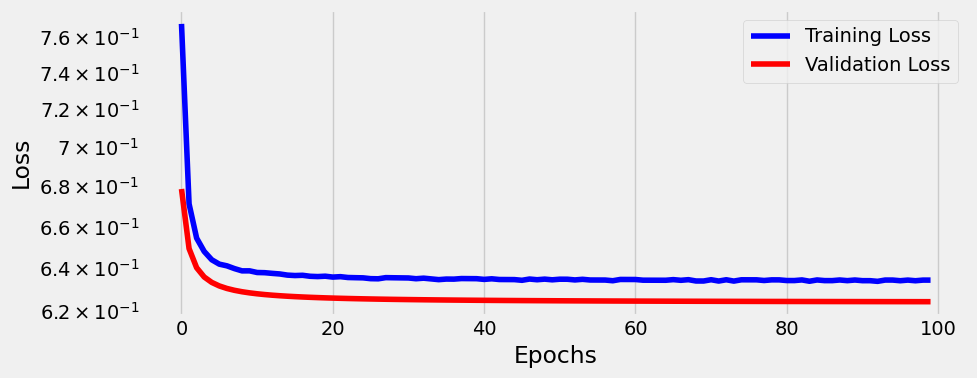

In [44]:
fig = arch.plot_losses()

In [45]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-1.1439e-01, -1.3414e-01, -9.9332e-02,  1.2000e-01,  2.1713e-01,
          1.4079e-02,  4.7857e+00,  3.9265e-02,  4.9743e-02,  5.1935e-02,
          1.6557e-02,  3.6983e-02, -1.4055e-02,  4.8939e-02, -2.9541e-03,
          1.2940e-02,  4.8870e-02,  1.6927e-02,  1.8838e-02,  2.2757e-02,
          1.9966e-02,  1.9484e-02, -2.5586e-03,  3.4327e-02, -8.4355e-02,
         -1.6164e-01, -1.1260e-01, -2.9299e-02, -3.9328e-02, -1.0424e-01]])), ('linear.bias', tensor([-4.9788]))])


#Making predictions

In [46]:
# prediction logits (z)
logits_val = arch.predict(X_val)
logits_val

array([[0.00087771],
       [0.00089119],
       [0.00076951],
       ...,
       [0.00043231],
       [0.00082239],
       [0.00067781]], dtype=float32)

In [47]:
# prediction probabilities
prob_val = torch.sigmoid(torch.as_tensor(logits_val).float())
prob_val

tensor([[0.5002],
        [0.5002],
        [0.5002],
        ...,
        [0.5001],
        [0.5002],
        [0.5002]])

In [50]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-1.1439e-01, -1.3414e-01, -9.9332e-02,  1.2000e-01,  2.1713e-01,
          1.4079e-02,  4.7857e+00,  3.9265e-02,  4.9743e-02,  5.1935e-02,
          1.6557e-02,  3.6983e-02, -1.4055e-02,  4.8939e-02, -2.9541e-03,
          1.2940e-02,  4.8870e-02,  1.6927e-02,  1.8838e-02,  2.2757e-02,
          1.9966e-02,  1.9484e-02, -2.5586e-03,  3.4327e-02, -8.4355e-02,
         -1.6164e-01, -1.1260e-01, -2.9299e-02, -3.9328e-02, -1.0424e-01]])), ('linear.bias', tensor([-4.9788]))])


#Classification Threshold

In [51]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [52]:
logits_val = arch.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

#Data Visualization

In [53]:


def probability_line(ax, y, probs, threshold, shift=0.0, annot=False, colors=None):
    if colors is None:
        colors = ['r', 'b']
    ax.grid(False)
    ax.set_ylim([-.1, .1])
    ax.axes.get_yaxis().set_visible(False)
    ax.plot([0, 1], [0, 0], linewidth=2, c='k', zorder=1)
    ax.plot([0, 0], [-.1, .1], c='k', zorder=1)
    ax.plot([1, 1], [-.1, .1], c='k', zorder=1)

    tn = (y == 0) & (probs < threshold)
    fn = (y == 0) & (probs >= threshold)
    tp = (y == 1) & (probs >= threshold)
    fp = (y == 1) & (probs < threshold)

    ax.plot([threshold, threshold], [-.1, .1], c='k', zorder=1, linestyle='--')
    ax.scatter(probs[tn], np.zeros(tn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[0], linewidth=3)
    ax.scatter(probs[fn], np.zeros(fn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[1], linewidth=3)

    ax.scatter(probs[tp], np.zeros(tp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probs[fp], np.zeros(fp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[0], linewidth=3)

    ax.set_xlabel(r'$\sigma(z) = P(y=1)$')
    ax.set_title('Threshold = {}'.format(threshold))

    if annot:
        ax.annotate('TN', xy=(.20, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('FN', xy=(.20, -.08), c='k', weight='bold', fontsize=20)
        ax.annotate('FP', xy=(.70, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('TP', xy=(.70, -.08), c='k', weight='bold', fontsize=20)
    return ax

In [54]:
def probability_contour(ax, model, device, X, y, threshold, cm=None, cm_bright=None):
    if cm is None:
        cm = plt.cm.RdBu
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    h = .02  # step size in the mesh

    x_min, x_max = -2.25, 2.25
    y_min, y_max = -2.25, 2.25

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    logits = logits.detach().cpu().numpy().reshape(xx.shape)

    yhat = sigmoid(logits)

    ax.contour(xx, yy, yhat, levels=[threshold], cmap="Greys", vmin=0, vmax=1)
    contour = ax.contourf(xx, yy, yhat, 25, cmap=cm, alpha=.8, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$\sigma(z) = P(y=1)$')
    ax.grid(False)

    ax_c = plt.colorbar(contour)
    ax_c.set_ticks([0, .25, .5, .75, 1])
    return ax

In [55]:
def figure9(x, y, model, device, probabilities, threshold, shift=0.0, annot=False, cm=None, cm_bright=None):
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(3, 3)

    ax = fig.add_subplot(gs[:, 0])
    probability_contour(ax, model, device, x, y, threshold, cm, cm_bright)

    if cm_bright is None:
        colors = ['r', 'b']
    else:
        colors = cm_bright.colors

    ax = fig.add_subplot(gs[1, 1:])
    probability_line(ax, y, probabilities, threshold, shift, annot, colors)

    fig.tight_layout()
    return fig

In [56]:
def figure10(y, probabilities, threshold, shift, annot, colors=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    probability_line(ax, y, probabilities, threshold, shift, annot, colors)
    fig.tight_layout()
    return fig

#Confusion Matrix

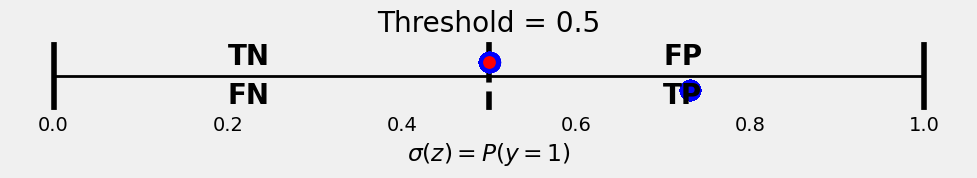

In [57]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

In [58]:
len(y_val)

1239

#Metrics

In [59]:
def split_cm(cm):
    # Actual negatives go in the top row,
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row,
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]

    return tn, fp, fn, tp

##True and false positive rates:
$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

In [60]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr

##Precision and recall:
$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [61]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

##Accuracy:
$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

In [62]:
logits_val = arch.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[   0, 1012],
       [   0,  227]])

In [63]:
precision_recall(cm_thresh50)

(np.float64(0.18321226795803067), np.float64(1.0))

In [64]:
acc = accuracy_score(y_val, (probabilities_val >= 0.5))
acc

0.18321226795803067

In [65]:
tpr_fpr(cm_thresh50)

(np.float64(1.0), np.float64(1.0))